In [1]:
from keras_segmentation.models import unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re

Using TensorFlow backend.
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/t

In [2]:
model = unet.mobilenet_unet(n_classes=4, input_height=224, input_width=224)
model.load_weights('segm_mob_224_224.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def find_segments(mask_img,cls):
    segments={}
    for cl in cls:
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_indecies = np.where(cols>=np.mean(cols[cols>4])/2)[0]
        row_indecies = np.where(rows>=np.mean(rows[rows>4])/2)[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    
    return segments

def crop_rect(im, rect, scaler={'h': 1, 'w': 1}):
    crop_img = im[rect[0][1]*scaler['h']:rect[1][1]*scaler['h'], rect[0][0]*scaler['w']:rect[1][0]*scaler['w']]
    #[(x1,y1),(x2,y2)]
    coordinates = [(rect[0][0]*scaler['w'],rect[0][1]*scaler['h']),
                   (rect[1][0]*scaler['w'],rect[1][1]*scaler['h'])]
            
    return crop_img, coordinates

def detect_classes(img,n_classes):
    # result is better when we know names of classes
    labels, counts = np.unique(img,return_counts=True)
    labels = labels[1:]
    counts = counts[1:]
    inds = np.argsort(counts)
    list_classes = []
    for i in range(1,n_classes+1):
        list_classes.append(labels[inds[-i]])
    return list_classes

In [4]:
test_data = pd.read_csv('test_labeled_dataset/data.csv')
test_data = test_data.rename(columns={'class':'labels'})
test_data['img_type'] = test_data['fname'].apply(lambda x: 1 if int(re.findall(r'\d+',x.split('.')[0])[0])<11 else 2)
test_data['fname'] = test_data['fname'].apply(lambda x: x[3:])
test_data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,87,20,1190,0,1195,113,81,138,1,01.jpg,1
1,78,155,1196,125,1222,564,46,556,2,01.jpg,1
2,173,195,1900,203,1927,395,159,391,1,02.jpg,1
3,143,411,1927,419,2011,1090,79,1120,2,02.jpg,1
4,485,165,3769,177,3745,581,509,541,1,03.jpg,1


In [5]:
def create_annotations(FF,img_folder, annotation_folder):
    for f in FF.fname.unique():
        img = cv2.imread(img_folder+f)
        mask = np.zeros(img.shape)
        T = FF[FF.fname==f]
        for cl in T['labels']:
            pts = T[T['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
            pts = pts.astype('int')
            mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
        cv2.imwrite(annotation_folder+f.split('.')[0]+'.png',mask)

In [6]:
#let's create annotations
img_folder = 'test_labeled_dataset/data/'
annotation_folder = 'test_labeled_dataset/annotations/'
#create_annotations(test_data,img_folder, annotation_folder)

Find segments: 2


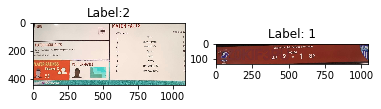

In [7]:
f=test_data['fname'][0]
img = cv2.imread(img_folder+f)
img_r = cv2.resize(img, (224,224))
n_classes = 2
out = model.predict_segmentation(img_r)
h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }
list_cls = detect_classes(out,n_classes)
rects = find_segments(out,list_cls)
segments = {}
for r in rects:
    crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
    segments[r]={'data': crop_img, 'coordinates':coordinates}
print(f'Find segments: {len(segments.keys())}')
plt.subplot(1,2,1)
plt.title(f"Label:{list_cls[0]}")
plt.imshow(segments[list_cls[0]]['data'])
plt.subplot(1,2,2)
plt.title(f"Label: {list_cls[1]}")
plt.imshow(segments[list_cls[1]]['data'])

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


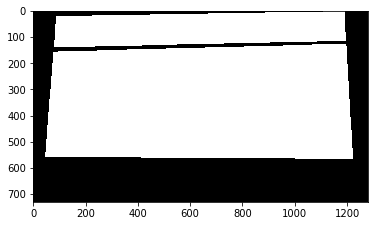

In [8]:
#show mask
mask = np.zeros(img.shape)
pts_1= test_data[test_data.fname==f][test_data['labels']==1].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts_1],color=(1,1,1))
pts_2= test_data[test_data.fname==f][test_data['labels']==2].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts_2],color=(1,1,1))
plt.imshow(mask)

In [9]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

In [10]:
pts_1= test_data[test_data.fname==f][test_data['labels']==1].values[0][:-3].astype('int').reshape(4,2)
m=np.array([[True,True],[False,False],[True,True],[False,False]])

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [11]:
pts_1

array([[  87,   20],
       [1190,    0],
       [1195,  113],
       [  81,  138]])

In [12]:
boxA=np.ravel(segments[1]['coordinates'])
boxB=pts_1[m]
print("prdicted: ",boxA)
print('real: ',boxB)
iou = bb_intersection_over_union(boxA, boxB)
print('IOU: ',iou)

prdicted:  [  88    0 1133  133]
real:  [  87   20 1195  113]
IOU:  0.67305559738784


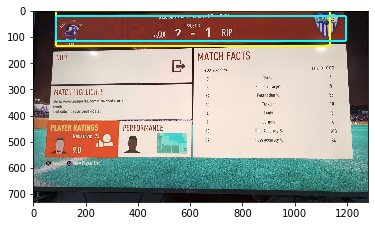

In [13]:
cv2.rectangle(img,(boxA[0],boxA[1]),(boxA[2],boxA[3]),(255,255,0),5)
cv2.rectangle(img,(boxB[0],boxB[1]),(boxB[2],boxB[3]),(0,255,255),5)

plt.imshow(img)

In [14]:
boxA=np.ravel(segments[2]['coordinates'])
boxB=pts_2[m]
print("prdicted: ",boxA)
print('real: ',boxB)
iou_2 = bb_intersection_over_union(boxA, boxB)
print('IOU: ',iou_2)

prdicted:  [  66  154 1155  595]
real:  [  78  155 1222  564]
IOU:  0.8679037800687285


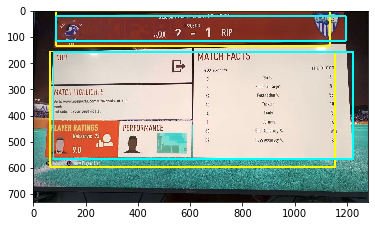

In [15]:
cv2.rectangle(img,(boxA[0],boxA[1]),(boxA[2],boxA[3]),(255,255,0),5)
cv2.rectangle(img,(boxB[0],boxB[1]),(boxB[2],boxB[3]),(0,255,255),5)

plt.imshow(img)

In [16]:
print('Average IOU: ', np.mean([iou,iou_2]))

Average IOU:  0.7704796887282843


In [69]:
f="01.jpg"
l=1
test_data[(test_data.fname==f)&(test_data.labels==1)]

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,87,20,1190,0,1195,113,81,138,1,01.jpg,1


In [26]:
m=np.array([[True,True],[False,False],[True,True],[False,False]])
n_classes = 2

predicted_boxes = {}
real_boxes = {}

IOUs = {}

for f in test_data.fname.unique():
    
    img = cv2.imread(img_folder+f)
    img_r = cv2.resize(img, (224,224))
    
    out = model.predict_segmentation(img_r)
    h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
    w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
    scaler = {'h': h_scale, 'w': w_scale, }
    list_cls = detect_classes(out,n_classes)
    rects = find_segments(out,list_cls)
    segments = {}
    for r in rects:
        crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
        segments[r]={'data': crop_img, 'coordinates':coordinates}
    
    predicted_boxes[f] = segments
    
    real_boxes[f]={}
    IOUs[f] = {}
    
    for l in test_data[test_data.fname==f].labels:
        pts=test_data[(test_data.fname==f)&(test_data.labels==l)].iloc[:,:-3].values[0].astype('int').reshape(4,2)
        real_boxes[f][l] = pts[m]
        
        boxA= np.ravel(segments[l]['coordinates'])
        boxB = pts[m]
    
        IOUs[f][l] = bb_intersection_over_union(boxA, boxB)

In [11]:
rects

{2: [(6, 22), (105, 85)], 1: [(8, 0), (103, 19)]}

In [27]:
IOUs

{'01.jpg': {1: 0.67305559738784, 2: 0.8679037800687285},
 '02.jpg': {1: 0.9398431474110315, 2: 0.9450827341464854},
 '03.jpg': {1: 0.9080654519622572, 2: 0.9340501495129685},
 '04.jpg': {1: 0.85311494805962, 2: 0.9264092696665513},
 '05.jpg': {1: 0.8233161911175021, 2: 0.9328857325487394},
 '06.jpg': {1: 0.8495831866381034, 2: 0.8668229240403892},
 '07.jpg': {1: 0.5361240424462521, 2: 0.924982230067653},
 '08.jpg': {1: 0.8109726555686906, 2: 0.934203748286641},
 '09.jpg': {1: 0.8938881466821409, 2: 0.9439754150822419},
 '10.jpg': {1: 0.7284838689114743, 2: 0.9318420633999982},
 '11.jpg': {1: 0.8811792109939066, 3: 0.941528657700715},
 '12.jpg': {1: 0.869502445362834, 3: 0.8861974012563463},
 '13.jpg': {1: 0.7373995114974047, 3: 0.9372713773994198},
 '14.jpg': {1: 0.9697494137062451, 3: 0.9304993919718533},
 '15.jpg': {1: 0.7960232957279729, 3: 0.8943320724586017},
 '16.jpg': {1: 0.9358397317094695, 3: 0.9313957281928797},
 '17.jpg': {1: 0.7725727516707889, 3: 0.8467813009807047},
 '18.

In [37]:
cls = np.unique(np.array([k for i in IOUs.keys() for k in IOUs[i].keys()]))

In [47]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')

In [48]:
# Average IOU by classes
ACC.mean()

1    0.832084
2    0.920816
3    0.924652
dtype: float64

Find segments: 2


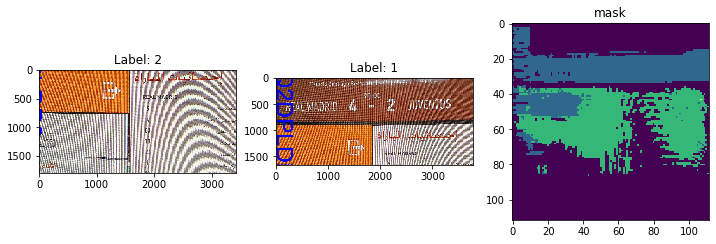

In [53]:
#0OQ2DPLDB0, 0B550D1F2A
f='0OQ2DPLDB0.jpg'
img = cv2.imread('test_img/'+f)
img_r = cv2.resize(img, (224,224))
n_classes = 2

out = model.predict_segmentation(img_r)

h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }

list_cls = detect_classes(out,n_classes)
rects = find_segments(out,list_cls)
segments = []
for r in rects:
    crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
    segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})
    
print(f'Find segments: {len(segments)}')
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title(f"Label: {segments[0]['label']}")
plt.imshow(segments[0]['data'])
plt.subplot(1,3,2)
plt.title(f"Label: {segments[1]['label']}")
plt.imshow(segments[1]['data'])
plt.subplot(1,3,3)
plt.title(f"mask")
plt.imshow(out)

Find segments: 2


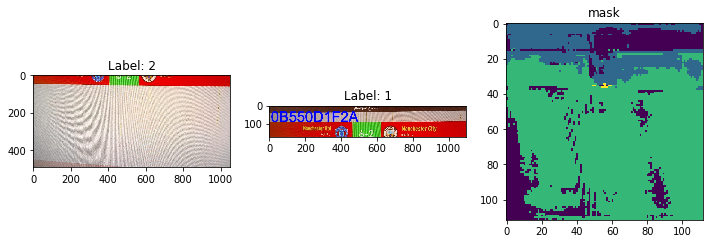

In [52]:
f='0B550D1F2A.jpg'
img = cv2.imread('test_img/'+f)
img_r = cv2.resize(img, (224,224))
n_classes = 2

out = model.predict_segmentation(img_r)

h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }

list_cls = detect_classes(out,n_classes)
rects = find_segments(out,list_cls)
segments = []
for r in rects:
    crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
    segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})
    
print(f'Find segments: {len(segments)}')
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title(f"Label: {segments[0]['label']}")
plt.imshow(segments[0]['data'])
plt.subplot(1,3,2)
plt.title(f"Label: {segments[1]['label']}")
plt.imshow(segments[1]['data'])
plt.subplot(1,3,3)
plt.title(f"mask")
plt.imshow(out)

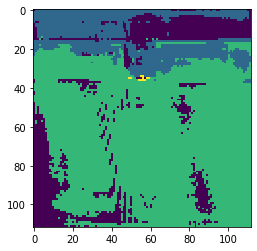

In [51]:
plt.imshow(out)

In [1]:
#time  execution, error code, message
#add logs, shape in, shape resize, shape out, tranzaction id, number of segments, coordinates
#del trace back
#documentation?
#logger.info(f"Raw OCR: {response}")
#decorator custom for time execution
a=[(80, 102), (368, 282)]

In [2]:
a[0][1]

102

In [3]:
import time

In [7]:
start_time = time.time()
start_time

1573818841.0740302

In [9]:
time_exec = (time.time() - start_time)/1000
time_exec

0.05090010666847229